### Import das bibliotecas utilizadas

In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from imblearn.over_sampling import SMOTE

### Seleciona acelX, acelY, acelZ e atividade

In [173]:
df_andando = pd.read_csv("C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Andando-PausasNãoMarcadas.csv")
df_correndo = pd.read_excel("C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Todas_as_Corridas.xlsx")
df_caindo = pd.read_excel("C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Todas_as_Quedas.xlsx")

colunas_selecionadas = ['acelX', 'acelY', 'acelZ', 'idTipoMovimento']

df_andando   = df_andando[colunas_selecionadas]
df_correndo  = df_correndo[colunas_selecionadas]
df_caindo    = df_caindo[colunas_selecionadas]

df_andando['idTipoMovimento'] = 'Andando'
df_correndo['idTipoMovimento'] = 'Correndo'
df_caindo['idTipoMovimento'] = 'Caindo'

# Selecionando somente as 500 primeiras linhas de cada dataset
# df_andando   = df_andando.head(500)
# df_caindo    = df_caindo.head(500)
# df_correndo  = df_correndo.head(500)

,acelX,acelY,acelZ,idTipoMovimento
0,3465.0,-2115.0,986.0,Andando
1,3131.0,-1980.0,418.0,Andando
2,1438.0,-588.0,3494.0,Andando
3,1281.0,-326.0,4320.0,Andando
4,1365.0,-840.0,2588.0,Andando
...,...,...,...,...
1687,2264.0,-816.0,2951.0,Andando
1688,2994.0,-2699.0,317.0,Andando
1689,3084.0,-1936.0,-443.0,Andando
1690,-3316.0,1776.0,1006.0,Andando


### Mensurar volume do dataset

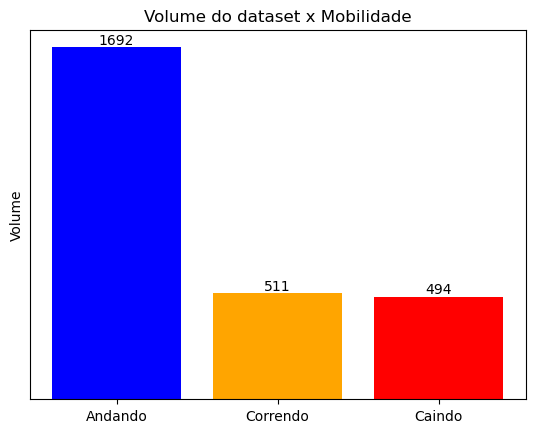

In [159]:
id_andando  = df_andando['idTipoMovimento'][0]
id_correndo = df_correndo['idTipoMovimento'][0]
id_caindo   = df_caindo['idTipoMovimento'][0]

eixo_x = [id_andando, id_correndo, id_caindo]
contagem = [len(df_andando),len(df_correndo),len(df_caindo)]
cores_barras = ['blue','orange','red']
legenda_barras = ['andando','correndo','caindo']

fig, ax = plt.subplots()

bar_container = ax.bar(eixo_x, contagem, label=legenda_barras, color=cores_barras)
ax.bar_label(bar_container, fmt='{:.0f}')
ax.set_title('Volume do dataset x Mobilidade')
# ax.set_xlabel('Mobilidade')
ax.set_ylabel('Volume')
# ax.legend()
plt.yticks([]) # Remover escala do eixo y
plt.xticks(eixo_x)
plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\volume_dataset_por_mobilidade.png')
plt.show()

### Adiciona cálculo da magnitude da aceleração

In [160]:
df_andando['MAGNITUDE_ACEL']   = np.sqrt(df_andando['acelX']**2 + df_andando['acelY']**2 + df_andando['acelZ']**2)
df_correndo['MAGNITUDE_ACEL']  = np.sqrt(df_correndo['acelX']**2 + df_correndo['acelY']**2 + df_correndo['acelZ']**2)
df_caindo['MAGNITUDE_ACEL']    = np.sqrt(df_caindo['acelX']**2 + df_caindo['acelY']**2 + df_caindo['acelZ']**2)


### Treinamento e teste do modelo (andando e correndo)

In [105]:
# df_andando_e_correndo = pd.concat([df_andando, df_correndo])

# X_train, X_test, y_train, y_test = train_test_split(df_andando_e_correndo[['acelX', 'acelY', 'acelZ', 'MAGNITUDE_ACEL']], df_andando_e_correndo['idTipoMovimento'], test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\knn_matriz_confusao_andando_correndo.png', dpi=300, bbox_inches='tight')

### Treinamento e teste do modelo (andando e caindo)

In [106]:
# df_andando_e_caindo = pd.concat([df_andando, df_caindo])

# X_train, X_test, y_train, y_test = train_test_split(df_andando_e_caindo[['acelX', 'acelY', 'acelZ', 'MAGNITUDE_ACEL']], df_andando_e_caindo['idTipoMovimento'], test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\knn_matriz_confusao_andando_caindo.png', dpi=300, bbox_inches='tight')

### Treinamento e teste do modelo (correndo e caindo)

In [107]:
# df_correndo_e_caindo = pd.concat([df_correndo, df_caindo])

# X_train, X_test, y_train, y_test = train_test_split(df_correndo_e_caindo[['acelX', 'acelY', 'acelZ', 'MAGNITUDE_ACEL']], df_correndo_e_caindo['idTipoMovimento'], test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\knn_matriz_confusao_correndo_caindo.png', dpi=300, bbox_inches='tight')

### Treinamento e teste do modelo (todas as mobilidades)

[[345   2   0]
 [  5  70  19]
 [  3  23  73]]
              precision    recall  f1-score   support

     Andando       0.98      0.99      0.99       347
      Caindo       0.74      0.74      0.74        94
    Correndo       0.79      0.74      0.76        99

    accuracy                           0.90       540
   macro avg       0.84      0.83      0.83       540
weighted avg       0.90      0.90      0.90       540



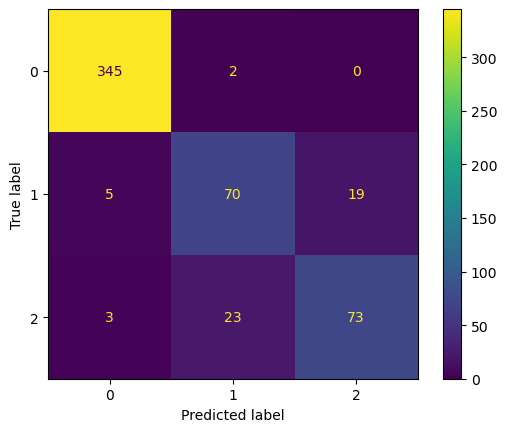

In [171]:
df_todos_os_movimentos = pd.concat([df_andando, df_correndo, df_caindo])

X_train, X_test, y_train, y_test = train_test_split(df_todos_os_movimentos[['acelX', 'acelY', 'acelZ','MAGNITUDE_ACEL']], df_todos_os_movimentos['idTipoMovimento'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\knn_matriz_confusao_todos_os_movimentos.png', dpi=300, bbox_inches='tight')

with open('modelos/knn_model.pkl', 'wb') as file:
    pickle.dump(knn, file)

In [170]:
df_teste_modelo = df_todos_os_movimentos
df_teste_modelo = df_teste_modelo.drop(columns=['idTipoMovimento'])
    
with open('modelos/knn_model.pkl', 'rb') as file:
    knn_loaded = pickle.load(file)
    
X_test = df_teste_modelo

y_pred = knn_loaded.predict(X_test)

print("Previsões: ", y_pred)

with open('predicoes/knn_predicoes.txt', 'w') as f:
    for pred in y_pred:
        f.write(f"{pred}\n")

print("Previsões salvas no arquivo 'predicoes/knn_predicoes.txt'")

c:\Users\julia\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Previsões:  ['Caindo' 'Caindo' 'Correndo' ... 'Caindo' 'Correndo' 'Caindo']
Previsões salvas no arquivo 'predicoes.txt'
